In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("StudyEventTimeSeries.csv")

In [3]:
import numpy as np

In [4]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [5]:
featureOnly= list(filter(lambda x: x.isupper(),codelist))
themeOnly= list(filter(lambda x: x.islower(),codelist))

In [6]:
# df["t"]=df.index

In [7]:
df = df.stack().reset_index()

In [8]:
df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

In [9]:
import altair as alt

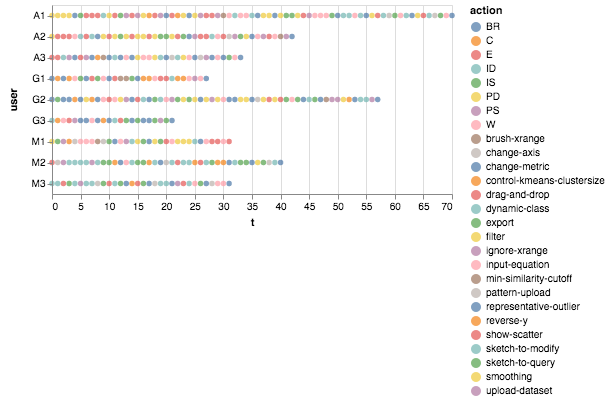

In [10]:
alt.Chart(df).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

# Action only

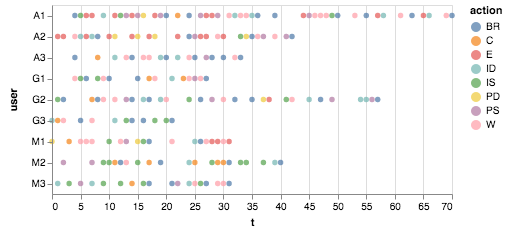

In [11]:
df_action = df[df.action.isin(featureOnly)]
alt.Chart(df_action).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

# Feature Only

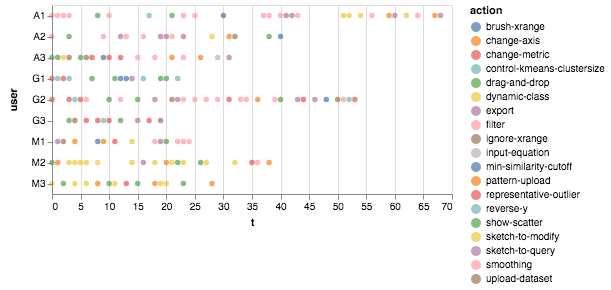

In [12]:
df_feature = df[~df.action.isin(featureOnly)]
alt.Chart(df_feature).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

In [13]:
# df_feature = df[~df.action.isin(featureOnly)]

# Key Components

In [14]:
component_dict = {
     'pattern-upload':'concept-query',
     'sketch-to-modify':'exact-specification',
     'drag-and-drop':'result-querying',
     'change-metric':'flexible-matching',
     'filter':'filter-selection',
     'brush-xrange':'range-selection',
     'min-similarity-cutoff':'control',
     'smoothing':'approx-shape-specification',
     'ignore-xrange':'approx-shape-specification',
     'representative-outlier':'recommendation',
     'dynamic-class':'group-comparison',
     'sketch-to-query':'exact-specification',
     'reverse-y':'control',
     'input-equation':'exact-specification',
     'upload-dataset':'control',
     'show-scatter':'control',
     'export':'control',
     'control-kmeans-clustersize':'recommendation',
     'change-axis':'control'
}

In [15]:
df_component = df_feature
df_component["action"] = df_feature["action"].replace(component_dict)
df_component= df_component.rename(index=str,columns={"action":"component"})

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# df_component = df_component[df_component["component"]!="control"] #remove control in list of components

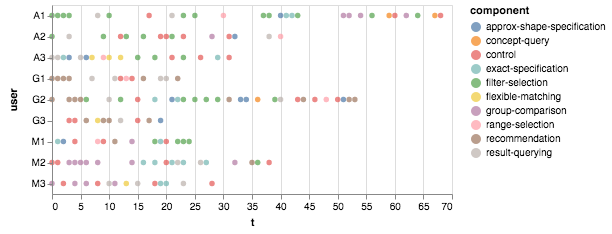

In [17]:
alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

# Adding some event action information back in

In [18]:
component_chart = alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

In [51]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_break).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [83]:
df_insight = df[df.action.isin(["IS","ID"])]
df_insight.loc[df_insight["action"]=="ID","action"]="data insight"
df_insight.loc[df_insight["action"]=="IS","action"]="scientific insight"
insight_chart = alt.Chart(df_insight).mark_point(shape="diamond",color="red").encode(        
    alt.Y("user",title="Participant"),
    alt.X("t",title="Timepoint"),
    shape='action' #make no distinction between data and science insights
)


/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


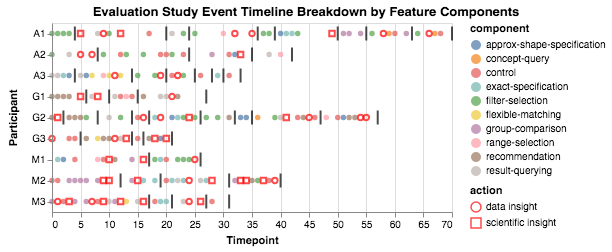

In [108]:
chart = component_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Feature Components"
chart

- Astronomers discovered insights more about their data, whereas geneticists and material scientists uncovered more scientific insights.
- The use of exact specification (including sketch) is rare, and doesn't usually lead to useful outcomes. 

# Processes

In [89]:
df_component["component"].unique()

array(['filter-selection', 'result-querying', 'recommendation', 'control',
       'group-comparison', 'exact-specification',
       'approx-shape-specification', 'flexible-matching',
       'range-selection', 'concept-query'], dtype=object)

In [95]:
td = '1-top-down-querying'
sc = '2-search-with-context'
bu = '3-bottom-up-querying'
rec= '4-recommendation'
component_to_process = {
    'exact-specification':td,
    'approx-shape-specification':td,
    'flexible-matching':td,
    'range-selection':td, 
    'filter-selection':sc, 
    'group-comparison':sc,
    'result-querying':bu,
    'concept-query':bu,
    'control':"others",
    'recommendation':rec,
}

In [96]:
df_process = df_component
df_process["process"] = df_component["component"].replace(component_to_process)

In [97]:
process_chart = alt.Chart(df_component).mark_circle().encode(        
    color='process',
    y="user",
    x='t'
)

In [99]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_break).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [100]:
df_insight = df[df.action.isin(["IS","ID"])]
df_insight.loc[df_insight["action"]=="ID","action"]="data insight"
df_insight.loc[df_insight["action"]=="IS","action"]="scientific insight"
insight_chart = alt.Chart(df_insight).mark_point(shape="diamond",color="red").encode(        
    alt.Y("user",title="Participant"),
    alt.X("t",title="Timepoint"),
    shape='action' #make no distinction between data and science insights
)


/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


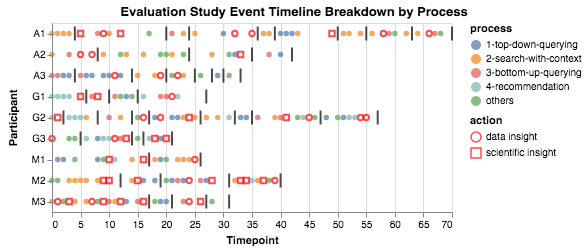

In [107]:
chart = process_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Process"
chart

- Top-down querying alone does not lead to insights. We see a lot of sessions where people try top-down querying then give up without discovering an insight. Even when there is top-down querying performed sucessfully, it is often because it was associated with a search with context, or used for sketch modification on a drag-and-dropped visualization.

# Statistics

In [113]:
print ("Total number of sessions:", len(df[df["action"]=="BR"]))

Total number of sessions: 47


In [125]:
df = pd.read_csv("StudyEventTimeSeries.csv")

In [139]:
sessions=[]
for row in df.as_matrix().T: 
    session=[]
    for action in row:
        if action != np.NaN:
            if action=="BR":
                sessions.append(session)
                session=[]
            else:
                session.append(action)
    sessions.append(session)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [140]:
sessions

[['filter', 'filter', 'filter', 'filter'],
 ['IS',
  'E',
  'E',
  'drag-and-drop',
  'ID',
  'filter',
  'E',
  'IS',
  'PS',
  'E',
  'PS',
  'PD',
  'reverse-y',
  'E',
  'PS'],
 ['drag-and-drop', 'C', 'filter'],
 ['filter', 'PS', 'E', 'E', 'PS', 'brush-xrange', 'W', 'ID', 'W', 'W', 'ID'],
 ['filter', 'filter'],
 ['smoothing',
  'sketch-to-query',
  'sketch-to-query',
  'filter',
  'E',
  'PS',
  'W',
  'W',
  'W',
  'IS'],
 ['dynamic-class', 'dynamic-class', 'W', 'dynamic-class'],
 ['filter', 'E', 'ID', 'pattern-upload', 'export', 'W', 'dynamic-class'],
 ['filter', 'E', 'ID', 'pattern-upload', 'export', 'W'],
 [],
 ['filter', 'E', 'E', 'drag-and-drop', 'W', 'ID', 'E', 'ID'],
 ['filter',
  'E',
  'PD',
  'export',
  'filter',
  'E',
  'PD',
  'filter',
  'E',
  'PD',
  'export',
  'export',
  'filter',
  'E',
  'export'],
 ['PS',
  'E',
  'E',
  'dynamic-class',
  'W',
  'E',
  'change-axis',
  'ignore-xrange',
  'IS',
  'PD'],
 ['W', 'PS', 'drag-and-drop', 'W', 'brush-xrange', 'PS'

In [133]:
"Number of sessions with at least one insight:"

'Number of sessions with at least one insight:'